## ROME - models + obs

ROME - organisation metric calculated from contiguous convective regions <br>
ROME_n - organisation metric calculated from the n (8) largest contiguous convective regions

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import skimage.measure as skm

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from metric_plotFuncs import *

In [7]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',       # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    # ''
    ]
model = models[0]

observations = [
    'GPCP'
    # ''
    ]
obs = observations[0]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]   

variable_options = [
    'rome'
    # 'rome_n'
    ]
variable_option = variable_options[0]


if model:
    precip = xr.open_dataset(home + '/Documents/data/cmip5/ds' + '/' + model + '_precip_' + experiment + '.nc').precip*60*60*24
    precip.attrs['units']= 'mm/day'

    var = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_rome_' + experiment + '.nc')[variable_option]

if obs:
    precip_obs = xr.open_dataset(home + '/Documents/data/obs/ds' + '/' + obs + '_precip.nc').precip
    var_obs = xr.open_dataset(home + '/Documents/data/obs/GPCP' + '/' + obs + '_rome.nc')[variable_option]

## example of scene for assessing ROME

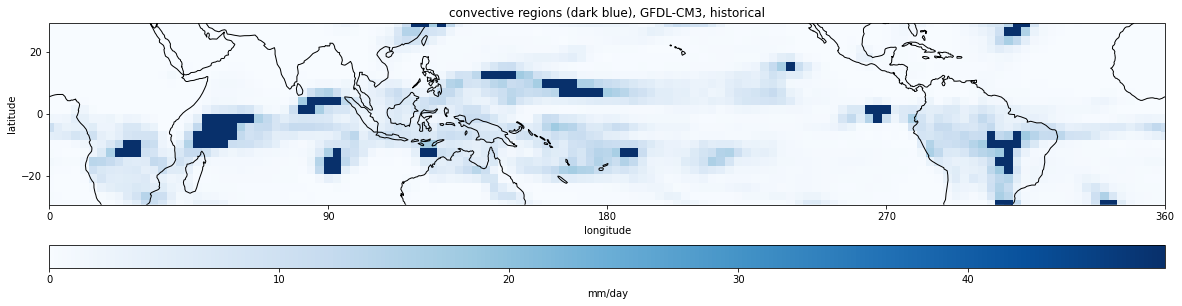

In [8]:
day =0
if model:
    scene_background = precip.isel(time=day)
    threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc').pr97.mean(dim='time').values
    L = skm.label(scene_background.where(scene_background>=threshold,0)>0, background=np.nan,connectivity=2)
    L = (L>0)*1
    labelMatrix = xr.DataArray(
        data=L,
        dims=['lat', 'lon'],
        coords={'lat': scene_background.lat.data, 'lon': scene_background.lon.data}
        )
    scene = labelMatrix.where(labelMatrix>0)
    cmap_background= 'Blues'
    cmap = 'Blues_r'
    title = 'convective regions (dark blue), ' + model + ', ' + experiment

    plot_sceneThreshold(scene_background, scene, cmap_background, cmap, title)

## one model / obs

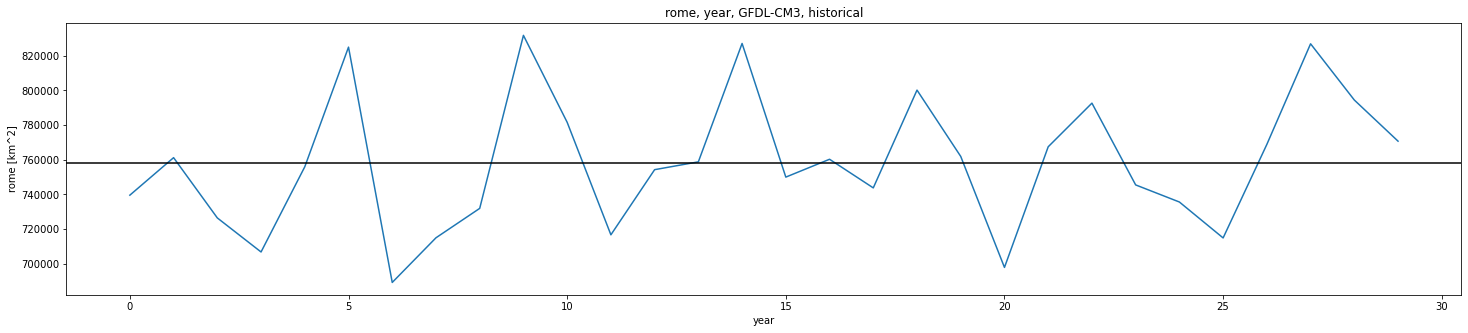

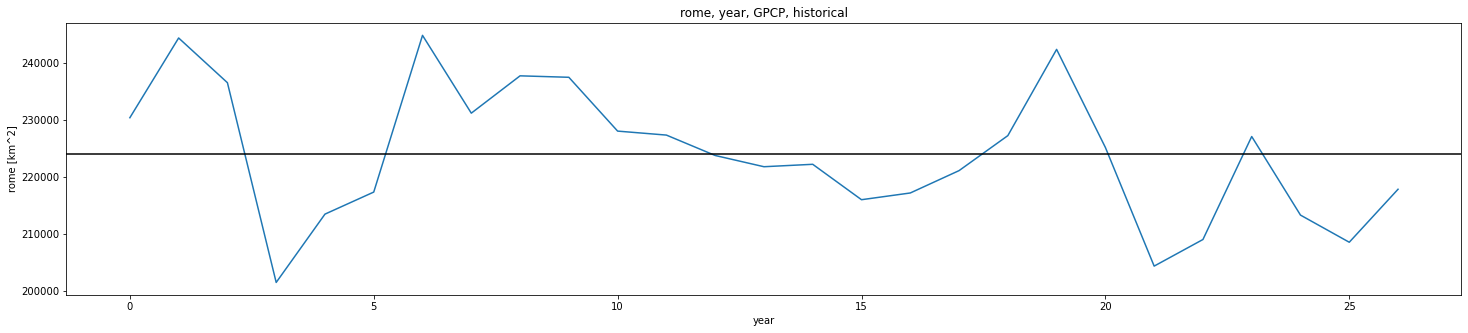

In [16]:
timeMean_options = [
    'year'
    # 'season'
    # 'season_mean'
    # 'month'
    # 'month_mean'
    # 'day'
    ]
timeMean_option = timeMean_options[0]

if model:
    title = variable_option + ', '+ timeMean_option + ', ' + model + ', ' + experiment

    if timeMean_option == 'year':
        y = var.resample(time='Y').mean(dim='time', keep_attrs=True)

        plot_timeseries(y, variable_option, timeMean_option, title)

    if timeMean_option == 'month':
        y = var.resample(time='M').mean(dim='time', keep_attrs=True)

        plot_timeseries(y, variable_option, timeMean_option, title)

    if timeMean_option == 'day':
        y = var

        plot_timeseries(y, variable_option, timeMean_option, title)
    
    if timeMean_option == 'season':
        y = var.resample(time='QS-DEC').mean(dim="time")
        y = to_monthly(y)
        y = y.rename({'month':'season'})
        y = y.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

        y.plot(x='year', hue='season', figsize=(25,5))
        plt.title(title)

    if timeMean_option == 'season_mean':
        y = var.resample(time='QS-DEC').mean(dim="time")
        y = to_monthly(y)
        y = y.rename({'month':'season'})
        y = y.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

        plt.figure(figsize=(10,2.5))
        ax = plt.gca()
        (y.mean(dim='year') - y.mean(dim='year').mean(dim='season')).to_series().plot.bar(ax=ax)
        plt.axhline(y=0, color='k', linestyle='--')

        ax.set_xticklabels(y.season.values, rotation=30, ha='right')
        plt.title(title  + ', anomaly from annual mean')


    if timeMean_option == 'month_mean':
        y = to_monthly(var)
        y = y.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])
        y.mean(dim='year').plot(figsize = (10,2.5))
        plt.title(title)

if obs:
    title = variable_option + ', '+ timeMean_option + ', ' + obs + ', ' + experiment

    if timeMean_option == 'year':
        y = var_obs.resample(time='Y').mean(dim='time', keep_attrs=True)

        plot_timeseries(y, variable_option, timeMean_option, title)

    if timeMean_option == 'month':
        y = var_obs.resample(time='M').mean(dim='time', keep_attrs=True)

        plot_timeseries(y, variable_option, timeMean_option, title)

    if timeMean_option == 'day':
        y = var_obs

        plot_timeseries(y, variable_option, timeMean_option, title)
    
    if timeMean_option == 'season':
        y = var_obs.resample(time='QS-DEC').mean(dim="time")
        y = to_monthly(y)
        y = y.rename({'month':'season'})
        y = y.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

        y.plot(x='year', hue='season', figsize=(25,5))
        plt.title(title)

    if timeMean_option == 'season_mean':
        y = var_obs.resample(time='QS-DEC').mean(dim="time")
        y = to_monthly(y)
        y = y.rename({'month':'season'})
        y = y.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

        plt.figure(figsize=(10,2.5))
        ax = plt.gca()
        (y.mean(dim='year') - y.mean(dim='year').mean(dim='season')).to_series().plot.bar(ax=ax)
        plt.axhline(y=0, color='k',linestyle='--')

        plt.title(obs + ', anomaly from annual mean')
        ax.set_xticklabels(y.season.values, rotation=30, ha='right')


    if timeMean_option == 'month_mean':
        y = to_monthly(var_obs)
        y = y.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])
        y.mean(dim='year').plot(figsize = (10,2.5))
        plt.title(title)


## models together / obs

In [18]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    'CNRM-CM5',     # 5
    # 'CCSM4',      # 6 # cannot concatanate files for rcp85 run
    'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    'inmcm4',       # 13
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    'HadGEM2-CC',   # 17
    'MRI-CGCM3',    # 18
    'CESM1-BGC'     # 19
    # ''
    ]
model = models[0]

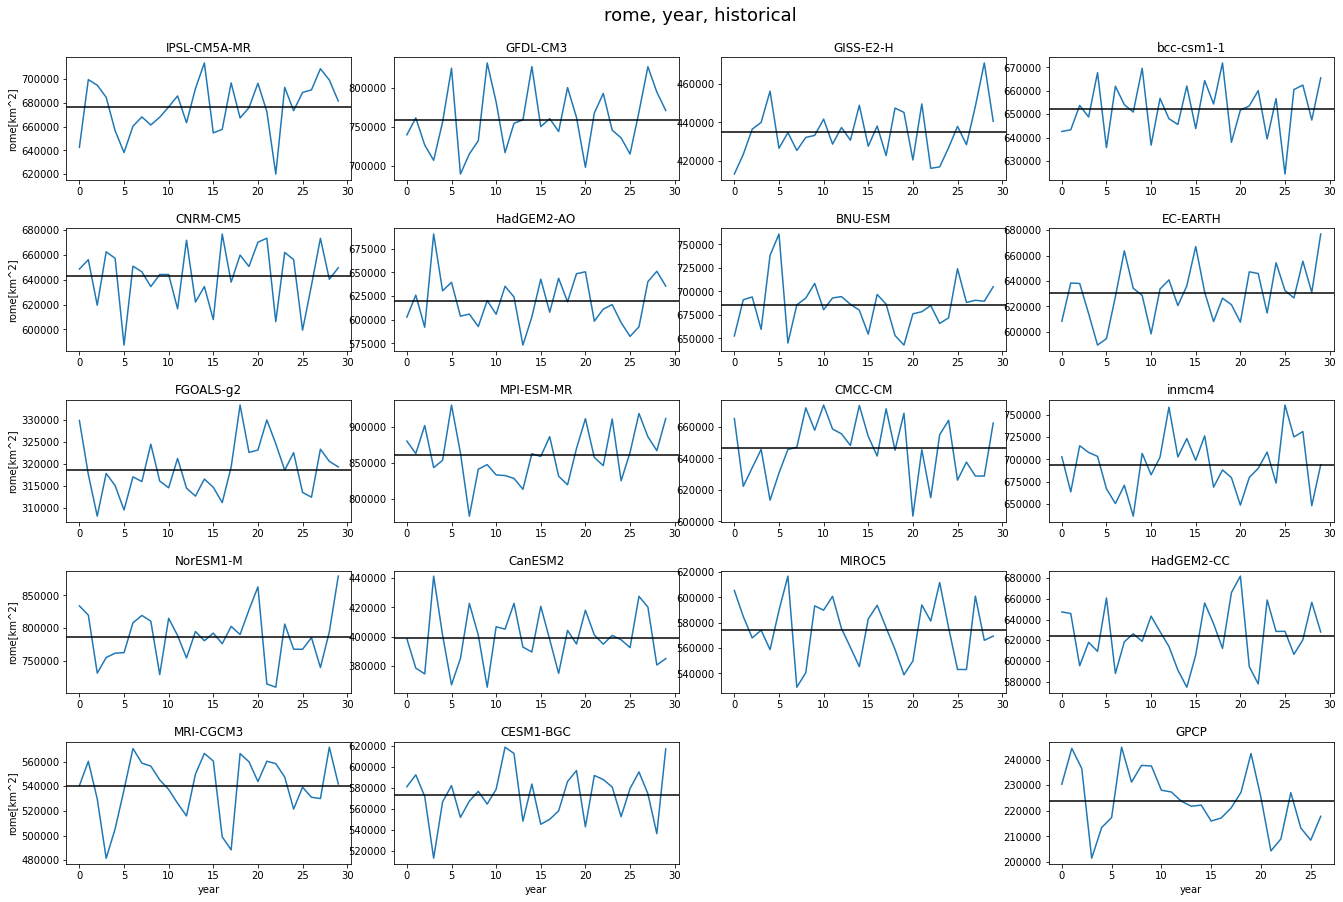

In [19]:
variable_file = 'rome'

timeMean_options = [
    'year'
    # 'season'
    # 'season_mean'
    # 'month'
    # 'month_mean'
    # 'day'
    ]
timeMean_option = timeMean_options[0]

title = variable_option + ', '+ timeMean_option + ', ' + experiment
vmin = None
vmax = None

plot_timeseries_tog(models, obs, home, experiment, 
                    variable_file, variable_option, 
                    timeMean_option, title)

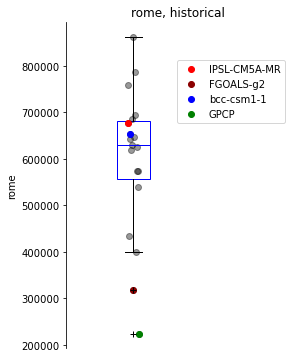

In [23]:
variable_file = 'rome'
box_types = [
    'experiment',
    # 'diff',
    # 'diff_tas'
]
box_type = box_types[0]

if box_type == 'experiment':
    title = variable_option + ', ' + experiment
    text_ylabel = variable_option

if box_type == 'diff':
    title = 'Difference in ' + variable_option
    text_ylabel = variable_option

if box_type == 'diff_tas':    
    title = 'Difference in ' + variable_option + '/K'
    text_ylabel = variable_option + ' [K' + chr(0x207B) + chr(0x00B9) + ']'

boxplotColor(home, models, variable_file, variable_option, box_type, experiment, obs, title, text_ylabel)